ここに従ってpytorchの転移学習実装を作る． https://torch.classcat.com/category/transfer-learning/

convnet を再調整する : ランダム初期化の代わりに、imagenet 1000 データセット上で訓練された一つのような、事前訓練されたネットワークでネットワークを初期化します。訓練の残りは通常のようなものです。

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/2023/splashlog
!ls

Mounted at /content/drive
/content/drive/MyDrive/2023/splashlog
 0927_make_yolo_annotations_main.ipynb	 main_icons
 230204_main_weapons			 sample.jpeg
 data					 scene_images
 hymenoptera_data			 Untitled0.ipynb
 hymenoptera_data.zip			'Untitled0.ipynb のコピー のコピー'
 hymenoptera_data.zip.1


In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from PIL import Image
import torch
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.nn import functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

データをロードするために torchvision と torch.utils.data パッケージを使用します。

https://reafnex.net/ai/pytorch-use-imagefolder/


次に、ImageFolderを使用して、先ほど作成したMNISTの手書き文字画像ファイルを取り込んでみます。最終的にバッチ分割されたデータローダーを作成します。

まずは、画像をテンソル化した後に、イメージ画像のデータ変換（標準化など）を行うクラスを定義します。

In [3]:
class ImageTransform():
  def __init__(self, mean, std):
    self.data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

次にImageFolderを使用して画像データの取り込みを行います。イメージ画像の格納状態は以下のようになっています。各数字の画像ファイルを格納しているディレクトリ名を、イメージ画像のラベルとして使用します。


・torchvision.datasets.ImageFolderは、イメージ画像ファイルを格納したディレクトリと画像変換設定を与えるだけなので、イメージ画像ファイルの整理さえできていれば、データ取込みがとても簡単にできてしまいます。PyTorchを使うならImageFolderを利用することで開発効率が格段にアップします。

以下のコードでイメージ画像の取り込みを行っています。

In [5]:
#画像データをImageFolderを使って取込みする
mean = (0.5,)
std = (0.5,)
#images = torchvision.datasets.ImageFolder( "/content/drive/MyDrive/2023/splashlog/230204_main_weapons", transform = ImageTransform(mean, std))
images = torchvision.datasets.ImageFolder( "../230204_main_weapons", transform = ImageTransform(mean, std))

In [6]:
n_classes = len(images.classes)
print(n_classes)

class_names = images.classes

f = open('main_weapon_list.txt', 'w')
for x in class_names:
    f.write(str(x) + "\n")
f.close()


64


https://qiita.com/takurooo/items/ba8c509eaab080e2752c

In [7]:
from torchvision import datasets

trainval_dataset = images

n_samples = len(trainval_dataset) # n_samples is 60000
train_size = int(len(trainval_dataset) * 0.8) # train_size is 48000
val_size = n_samples - train_size # val_size is 48000

# shuffleしてから分割してくれる.
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

print(len(train_dataset)) # 48000
print(len(val_dataset)) # 12000


test_dataset, val_dataset = torch.utils.data.random_split(val_dataset, [len(val_dataset)//2, len(val_dataset)-len(val_dataset)//2])

print(len(train_dataset)) # 48000
print(len(val_dataset)) # 12000
print(len(test_dataset)) # 12000

8000
2000
8000
1000
1000


In [8]:
dataset_sizes = {"train":len(train_dataset), "val":len(val_dataset)}

In [9]:
dataloaders = {}
dataloaders["train"] = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=True, num_workers=4)
dataloaders["val"] = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=True, num_workers=4)

モデルを訓練する
さて、モデルを訓練するための一般的な関数を書きましょう。ここでは、次を示します :

・学習率をスケジューリングする

・ベスト・モデルをセーブする


以下で、パラメータ・スケジューラは torch.optim.lr_scheduler からの LR スケジューラ・オブジェクトです。


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
            #for inputs, labels in train_dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

モデル予測を可視化する
少数の画像のための予測を表示するための一般的な関数。

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNet を再調整する
事前訓練されたモデルをロードして最後の完全結合層をリセットします。

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#最初に、ResNet18モデルが事前学習済みであることを使用して、model_ftという変数にモデルを格納します。
model_ft = models.resnet18(pretrained=True)
#最後の完全結合層（全結合層）は、model_ft.fc = nn.Linear(num_ftrs, 2)という行でリセットされています。 この行では、元のモデルのfc層（出力層）が新しい線形層に置き換えられています。
#次に、出力層のノード数を2に設定するために、model_ft.fcを更新します。
num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, n_classes).
model_ft.fc = nn.Linear(num_ftrs, n_classes)

#次に、学習させるために、GPUまたはCPUにモデルを送信します。
model_ft = model_ft.to(device)

#損失関数として、クロスエントロピー損失関数を設定します。
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7862 Acc: 0.8107
val Loss: 0.0319 Acc: 0.9910

Epoch 1/9
----------
train Loss: 0.1252 Acc: 0.9685
val Loss: 0.0169 Acc: 0.9930

Epoch 2/9
----------
train Loss: 0.0870 Acc: 0.9783
val Loss: 0.0067 Acc: 0.9980

Epoch 3/9
----------
train Loss: 0.0621 Acc: 0.9851
val Loss: 0.0177 Acc: 0.9940

Epoch 4/9
----------
train Loss: 0.0460 Acc: 0.9884
val Loss: 0.0100 Acc: 0.9980

Epoch 5/9
----------
train Loss: 0.0452 Acc: 0.9895
val Loss: 0.0331 Acc: 0.9910

Epoch 6/9
----------
train Loss: 0.0362 Acc: 0.9919
val Loss: 0.0269 Acc: 0.9930

Epoch 7/9
----------
train Loss: 0.0242 Acc: 0.9944
val Loss: 0.0122 Acc: 0.9960

Epoch 8/9
----------
train Loss: 0.0226 Acc: 0.9951
val Loss: 0.0139 Acc: 0.9960

Epoch 9/9
----------
train Loss: 0.0160 Acc: 0.9969
val Loss: 0.0171 Acc: 0.9960

Training complete in 5m 28s
Best val Acc: 0.998000


In [15]:
torch.save(model_ft, 'main_weapons_classification_weight.pth')

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

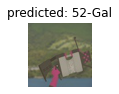

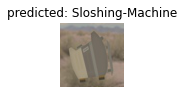

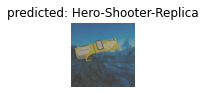

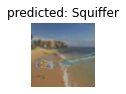

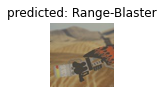

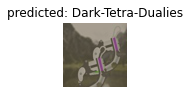

In [20]:
visualize_model(model_ft)

https://pystyle.info/pytorch-how-to-use-pretrained-model/

Transforms は Pillow の画像形式が対応しているので、PIL.Image.open() で読み込む。


Transforms で変換し、テンソルにする。


unsqueeze(0) でバッチ次元を追加する。形状を (C, H, W) から (1, C, H, W) にする。


to(device) で計算を行うデバイスに転送する。

In [24]:
img = Image.open("/content/drive/MyDrive/2023/splashlog/230204_main_weapons/52-Gal/1675487940.7994707.jpg")
transform = ImageTransform(mean, std)
inputs = transform(img)
inputs = inputs.unsqueeze(0).to(device)

eval() でモデルを推論モードに設定したら、順伝搬を行います。

In [27]:
model_ft.eval()
outputs = model_ft(inputs)
print(outputs)

tensor([[20.4677,  4.8384, -0.9472,  0.8996, -4.9405, -0.7169,  0.7509,  5.2645,
         -0.8794,  1.9928,  2.1711, -2.2498,  6.5845,  5.0865,  0.8510,  3.0526,
         -0.6773,  2.1317, -5.2350, -3.6149,  5.2123, -0.0461, -3.4643, -1.1745,
          2.7449, -2.9644,  2.2747, -7.7400,  0.6856,  0.5925,  0.2427,  0.7306,
         -0.7915,  2.8062,  0.5664, -3.2717,  1.9828, -0.7562, -0.1190, -0.6819,
          1.0356,  2.1912,  1.3361,  1.2719, -1.0634, -4.1387,  2.8622, -3.6811,
         -3.2674, -1.7282, -1.1092, -0.6082, -0.4426,  1.0074, -2.0136, -0.6906,
          0.3323, -2.9859, -4.8017, -2.5047, -0.1009, -3.3973,  1.0057, -4.5046]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [28]:
class_names

['52-Gal',
 '96-Gal',
 'Aerospray',
 'Aerospray-RG',
 'Ballpoint-Splatling',
 'Bamboozler-14-Mk-I',
 'Big-Swig-Roller',
 'Blaster',
 'Bloblobber',
 'Carbon-Roller',
 'Carbon-Roller-Deco',
 'Clash-Blaster',
 'Custom-Splattershot-Jr',
 'Dapple-Dualies',
 'Dapple-Dualies-Nouveau',
 'Dark-Tetra-Dualies',
 'Dualie-Squelchers',
 'Dynamo-Roller',
 'E-liter-4K',
 'Explosher',
 'Flingza-Roller',
 'Glooga-Dualies',
 'Goo-Tuber',
 'H-3-Nozzlenose',
 'Heavy-Splatling',
 'Hero-Shooter-Replica',
 'Hydra-Splatling',
 'Inkbrush',
 'Inkbrush-Nouveau',
 'Jet-Squelcher',
 'L-3-Nozzlenose',
 'LACT-450',
 'Luna-Blaster',
 'Luna-Blaster-Neo',
 'Mini-Splatling',
 'N-ZAP85',
 'Nautilus-47',
 'Octobrush',
 'Range-Blaster',
 'Rapid-Blaster',
 'Rapid-Blaster-Pro',
 'Slosher',
 'Slosher-Deco',
 'Sloshing-Machine',
 'Snipewriter-5H',
 'Splash-o-matic',
 'Splat-Brella',
 'Splat-Charger',
 'Splat-Dualies',
 'Splat-Roller',
 'Splatana-Stamper',
 'Splatana-Wiper',
 'Splattershot',
 'Splattershot-Jr',
 'Splattershot-No

In [31]:
batch_probs = F.softmax(outputs, dim=1)
batch_probs, batch_indices = batch_probs.sort(dim=1, descending=True)

In [32]:
for probs, indices in zip(batch_probs, batch_indices):
    for k in range(3):
        print(f"Top-{k + 1} {class_names[indices[k]]} {probs[k]:.2%}")

Top-1 52-Gal 100.00%
Top-2 Custom-Splattershot-Jr 0.00%
Top-3 Blaster 0.00%
